In [ ]:
'''Last modified 11.02.2016
    Added mongoDB functionality - one can query any data he wants DESCRIBE HOW TO DO THIS
    Pandas table can be used
09.02.2016
Nothing changed, database and pandas functionality should be added!!!
''';

In [ ]:
%pylab inline

In [ ]:
# imports

import sys
import os
par_dir = os.path.split(os.getcwd())[0]
if par_dir not in sys.path:
    sys.path.append(par_dir)
# sys.path.append(r'/Users/artemgolovizin/GitHub')
from scipy.optimize import curve_fit
import inspect
import pickle
import imp
import re
import json
import pandas as pd

from IPython.html import widgets
from IPython.display import display
from IPython.html.widgets import interact, interactive, fixed

import thulium_python_lib.usefull_functions as usfuncs
import thulium_python_lib.image_processing_new as impr

import ipyparallel as ipp
ipp.CompositeError.tb_limit = 1

rc1 = ipp.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
dview['par_dir'] = par_dir
# with dview.sync_imports():
#     import sys, os    
%px import sys, os
%px if par_dir not in sys.path: sys.path.append(par_dir)
%px import thulium_python_lib.image_processing_new as impr
%px import imp
%px from ipyparallel import bind_kernel; bind_kernel()

import datetime
import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId

# start mongoDB client (mongod server should be launched)
client = MongoClient('mongodb://192.168.1.15:27017/')
meas_database = client.measData.meas_data

In [ ]:
# to reload library on remote and local engine
# %px imp.reload(impr)
# imp.reload(impr)
# imp.reload(usfuncs)

In [ ]:
# OLD part for getting data from mongoDB
coursor = meas_database.find({'conf_params.SHUTTER':'on','meas_type':'T'})
tables = []
for item in coursor:
    for key in item:
        if(key == 'avr_table_pickle'):
            tables.append(pickle.loads(item[key]))
            print(key,item[key][-20:])
        else:
            print(key,item[key])
    print('\n')

In [ ]:
mmm = meas_database.find_one()
#print(mmm.keys())

In [ ]:
#datetime.datetime(2016, 2, 4, 0, 0) < datetime.datetime(2017, 2, 4, 0, 0)

In [ ]:
#mmm['date_meas']

In [ ]:
#x = copy(data)

In [ ]:
#meas_database.delete_one({'_id': ObjectId('57054a950aad402528297512')})
#data[61]
#int(data[12]['folder'].split()[0])
#for i in range(0,2):
#meas_database.delete_one({'_id': data[61]['_id']})
#for i in range(0,1):
    #meas_database.delete_one({'_id': data[i]['_id']})

In [942]:
powers = dict()
powers = {-9:(4.3-1.5),-8:(6-1.5),-7:(8.5-1.5),-6:13,-5:19,-4:29,-3:44,-2:67,-1:103,0:160,1:250,2:370,3:530,4:750,5:960,6:1180,7:1370,8:1570,9:1680,10:1710}
def sat_param(x):
    #return array(x), 'dBm at generator'
    return telescope*array([powers[key] for key in x])*1.38/320, 'Параметр насыщения s'
def detuning(x):
    return 2*(364.7 - array(x)), 'Отстройка, МГц'#/0.35
def B_z(x):
    return 19*array(x)/4, 'Магнитное поле, Гс/см'

In [874]:
γ=0.350 # MHz
Γ=2*pi*γ # MHz

hbar=10**(-34) # Дж*с

kB=1.38*10**(-23) # Дж/К

beams=6

λ=531*10**(-9) # nm
k=2*pi/λ

m=169*1.66*10**(-27) # kg
g=10

R=hbar*k*Γ*1e6/(2*m*g)
def Temperature1(δ,s): # U mode
    return (0.5*hbar*Γ*sqrt(1+beams*s)*1e6/kB)*(0.25*γ*sqrt(1+beams*s)/δ+δ/(γ*sqrt(1+beams*s)))*1e6
def Temperature2(δ,s): # V mode
    return (0.5*hbar*Γ*1e6*sqrt(s)/kB)*(0.5*R/sqrt(R-s/s-1/s))*1e6+0*δ

In [901]:
def dependency_list(data_local, alt_value, folder_start, folder_end):
    xx = []
    Tx = []
    Ty = []
    Na = []
    VertPos = []
    σx = []
    σy = []
    V = [] # объем
    na = [] # концентрация см^-3
    ρ = [] # фазовая плотность, безразмерная
    for d in data_local:
        folder_number = int(d['folder'].split()[0])
        if  folder_number >= folder_start and folder_number <= folder_end:
            xx.append(float(re.findall(r"[-+]?\d*\.?\d+",d['conf_params'][alt_value])[-1]))
            Tx1 = d['fits'][0][1][0]
            Tx.append(Tx1)
            Ty1 = d['fits'][1][1][0]
            Ty.append(Ty1)
            Na1 = d['avr_table']['fit1D_x']['N'][0]/1e6
            Na.append(Na1)
            VertPos.append(d['avr_table']['fit1D_y']['x0'][0]/1e3) # mm
            σx1 = d['avr_table']['fit1D_x']['sigma'][0]/1e3 # mm
            σx.append(σx1)
            σy1 = d['avr_table']['fit1D_y']['sigma'][0]/1e3 # mm
            σy.append(σy1)
            V1 = pi**1.5 * σy1 * σx1**2
            V.append(V1)
            na1 = Na1*1e9/V1
            na.append(na1)
            λx_dB = 1e5 * hbar * sqrt(2*pi/(m*kB*(Tx1+1))) # cm
            λy_dB = 1e5 * hbar * sqrt(2*pi/(m*kB*Ty1)) # cm
            na1 = 6.5 * 1e11
            ρ.append(na1 * λy_dB * λx_dB**2)
    
    if alt_value == 'F':    # перевод xx в отстройку
        xx, x_lbl = detuning(xx)
    if alt_value == 'A':    # перевод xx в параметр насыщения
        xx, x_lbl = sat_param(xx)
    if alt_value == 'AH':   # перевод xx в магнитное поле
        xx, x_lbl = B_z(xx)
    
    # упорядочим массивы в соответствии с массивом xx
    indexes_for_sort = []
    indexes_for_sort = argsort(xx)
    Tx = array(Tx)[indexes_for_sort]
    Ty = array(Ty)[indexes_for_sort]
    Na = array(Na)[indexes_for_sort]
    VertPos = array(VertPos)[indexes_for_sort]
    VertPos = min(VertPos) - VertPos
    σx = array(σx)[indexes_for_sort]
    σy = array(σy)[indexes_for_sort]
    na = array(na)[indexes_for_sort]
    ρ = array(ρ)[indexes_for_sort]
    xx = xx[indexes_for_sort]
    
    return array(list(zip(xx,Tx,Ty,Na,VertPos,σx,σy,na,ρ))), x_lbl

def drawing(tmp, x_lbl, k, graph_name, mset):
    nop = 20 # number of plots
    figsize(15,5*nop)
    nodp = 6
    
    subplot(nop,2,(k-1)*nodp+1)
    plot(tmp[:,0],tmp[:,1],mset[0], label='T гориз')
    plot(tmp[:,0],tmp[:,2],mset[1], label='T верт')
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Температура, мкК', fontsize=14, family="verdana")
    title(graph_name, fontsize=14, family="verdana")
    #legend()
    
    subplot(nop,2,(k-1)*nodp+2)
    plot(tmp[:,0],tmp[:,3],mset[2])
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Число атомов 10^6', fontsize=14, family="verdana")
    title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+3)
    plot(tmp[:,0],tmp[:,4],mset[2])
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Положение, мм', fontsize=14, family="verdana")
    title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+4)
    plot(tmp[:,0],tmp[:,5],mset[0])
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Размер, мм', fontsize=14, family="verdana")
    title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+4)
    plot(tmp[:,0],tmp[:,6],mset[1])
    xlabel(x_lbl, fontsize=14, family="verdana")
    #ylabel('Вертикальный размер, мм', fontsize=14, family="verdana")
    title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+5)
    plot(tmp[:,0],tmp[:,7],mset[2])
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Концентрация, см^-3', fontsize=14, family="verdana")
    title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+6)
    plot(tmp[:,0],tmp[:,8],mset[2])
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Фазовая плотность', fontsize=14, family="verdana")
    title(graph_name, fontsize=14, family="verdana")

# 2016_05_05

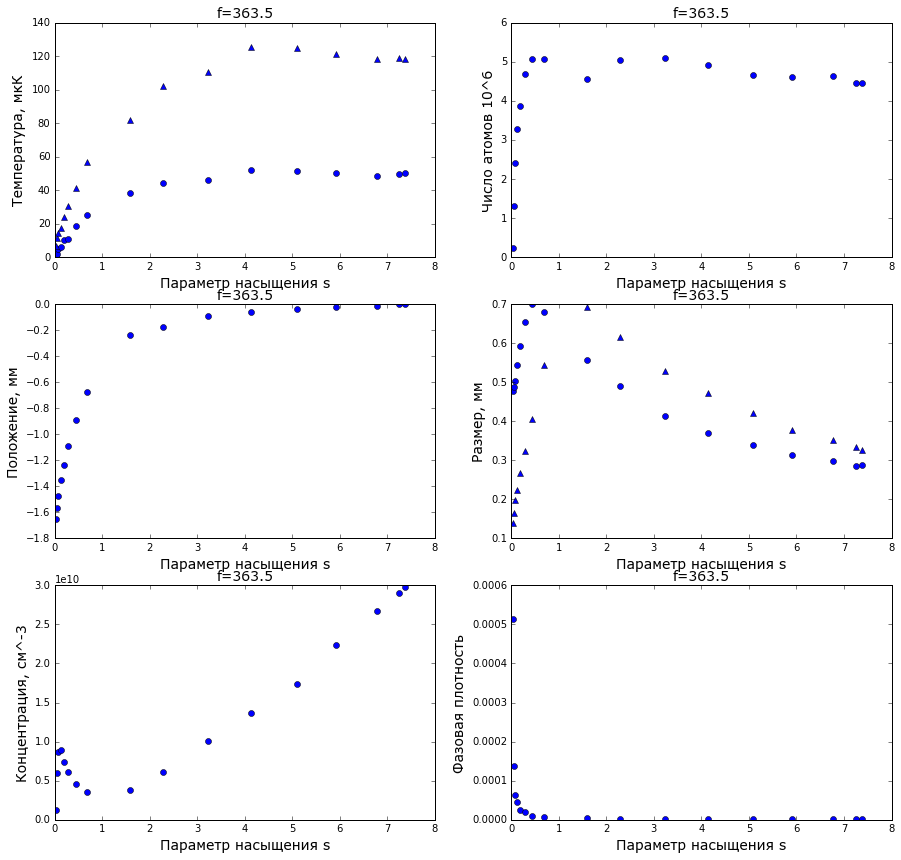

In [943]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 5, 0, 0), 'meas_type':'T', 'conf_params.F': '363.5' })
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')


    
# от мощности с телескопом (как обычно)
telescope = 1
tmp, x_lbl = dependency_list(data, 'A', 8, 25)

#print(tmp)
tmp = np.delete(tmp,8,axis=0)
#print(tmp)

drawing(tmp, x_lbl, 1, 'f=363.5', ['bo', 'b^', 'bo'])

vs_P_2016_05_05 = tmp

#print(data[0]['avr_table']['fit1D_y'])
#help(plot)

# 2016_05_06

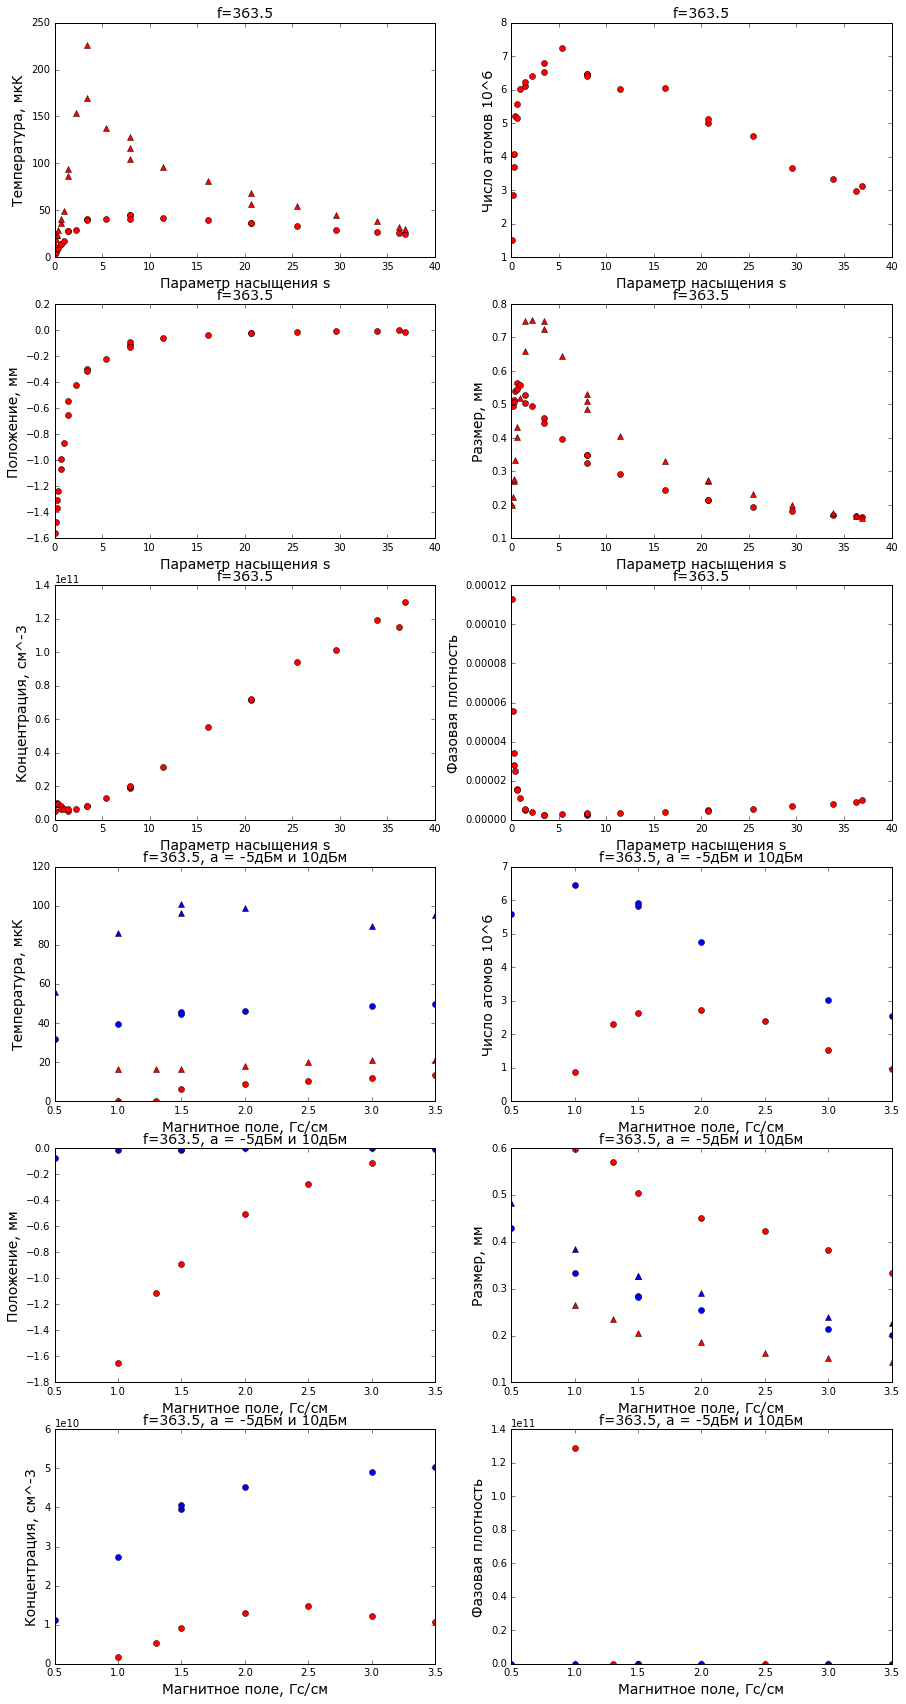

In [892]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 6, 0, 0), 'meas_type':'T', 'conf_params.F': '363.5' })
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')



# от мощности без телескопа
telescope = 4*1.25
tmp, x_lbl = dependency_list(data, 'A', 52, 77)

drawing(tmp, x_lbl, 1, 'f=363.5', ['ro', 'r^', 'ro'])

vs_P_wt_2016_05_06 = tmp

# от магнитного поля, -5 дБм

tmp, x_lbl = dependency_list(data, 'AH', 37, 43)

drawing(tmp, x_lbl, 2, 'f=363.5, a = -5дБм и 10дБм', ['ro', 'r^', 'ro'])

# от магнитного поля, 10 дБм

tmp, x_lbl = dependency_list(data, 'AH', 44, 51)

drawing(tmp, x_lbl, 2, 'f=363.5, a = -5дБм и 10дБм', ['bo', 'b^', 'bo'])

# 2016_05_07

1.17377263024


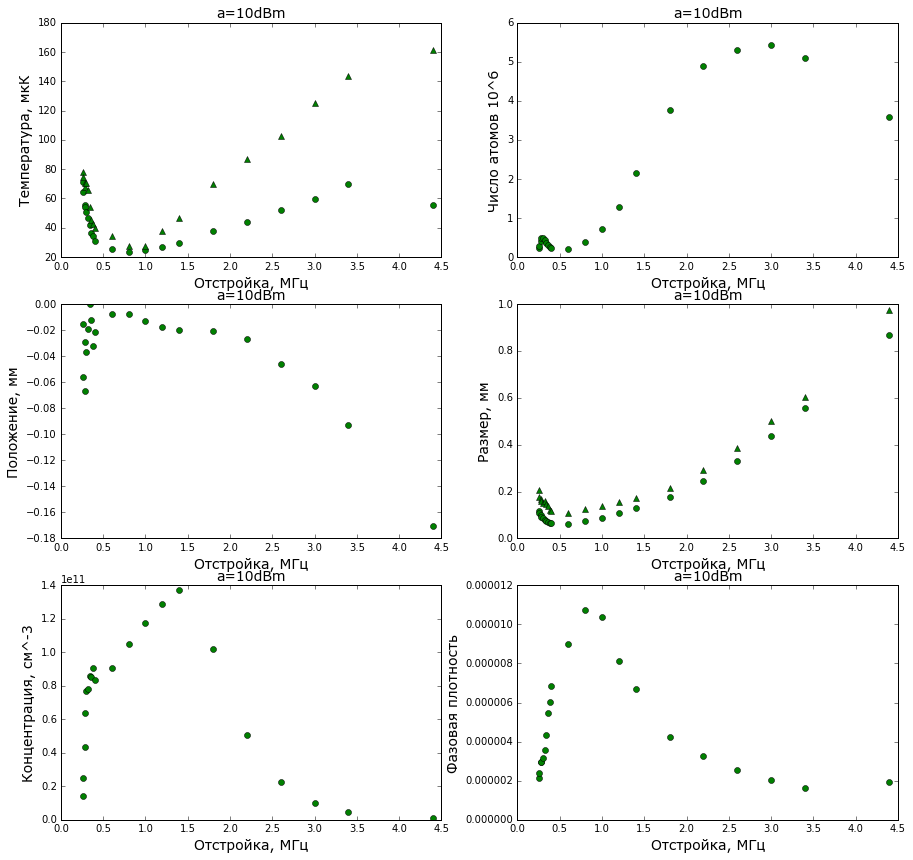

In [893]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 7, 0, 0), 'meas_type':'T'})
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')



# от отстройки
telescope = 1
tmp, x_lbl = dependency_list(data, 'F', 1, 21)

drawing(tmp, x_lbl, 1, 'a=10dBm', ['go', 'g^', 'go'])

#title('a=%idBm'%nop, fontsize=14, family="verdana")

vs_D_2016_05_07 = tmp

print(0.35*sqrt(1+6*1.7*1.38/0.32)/2)

# 2016_05_08

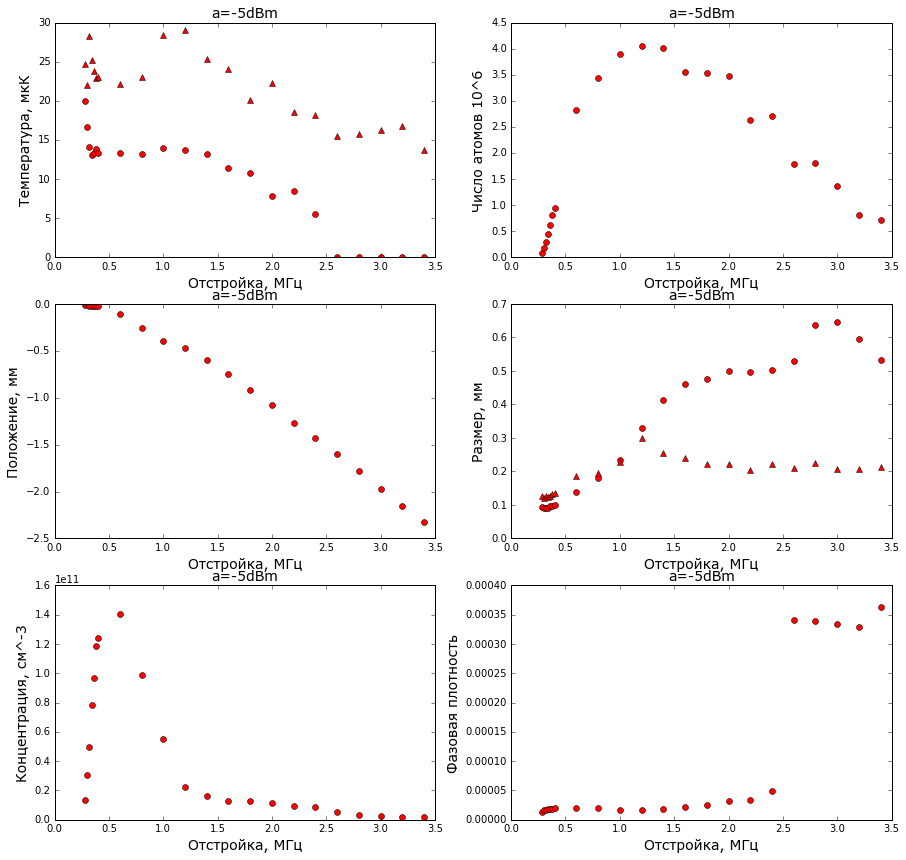

In [903]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 8, 0, 0), 'meas_type':'T'})
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')



# от отстройки
telescope = 1
tmp, x_lbl = dependency_list(data, 'F', 1, 25)

drawing(tmp, x_lbl, 1, 'a=-5dBm', ['ro', 'r^', 'ro'])

vs_D_2016_05_08 = tmp

# 2016_05_11

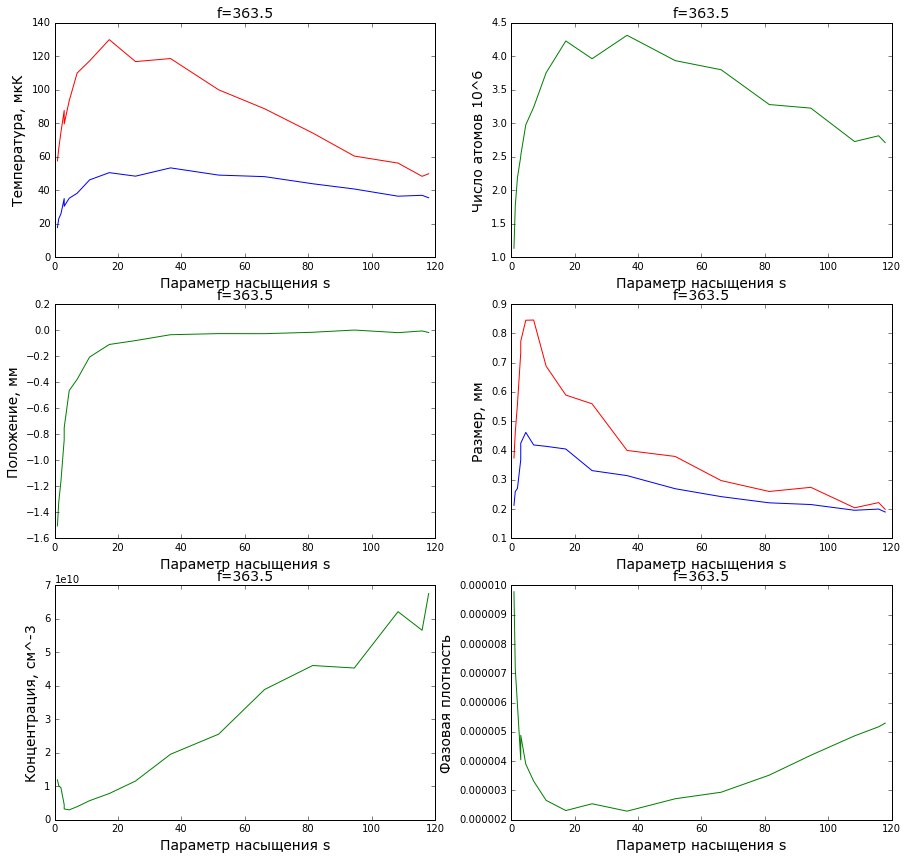

In [900]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 11, 0, 0), 'meas_type':'T'})#, 'conf_params.F': '363.5' 
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 5, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')
    

# от мощности с перевернутым телескопом
telescope = 4*4 #/6
tmp, x_lbl = dependency_list(data, 'A', 17, 34)

drawing(tmp, x_lbl, 1, 'f=363.5', ['b-', 'r-', 'g-'])

vs_P_wrt_2016_05_11 = tmp

# 2016_05_12

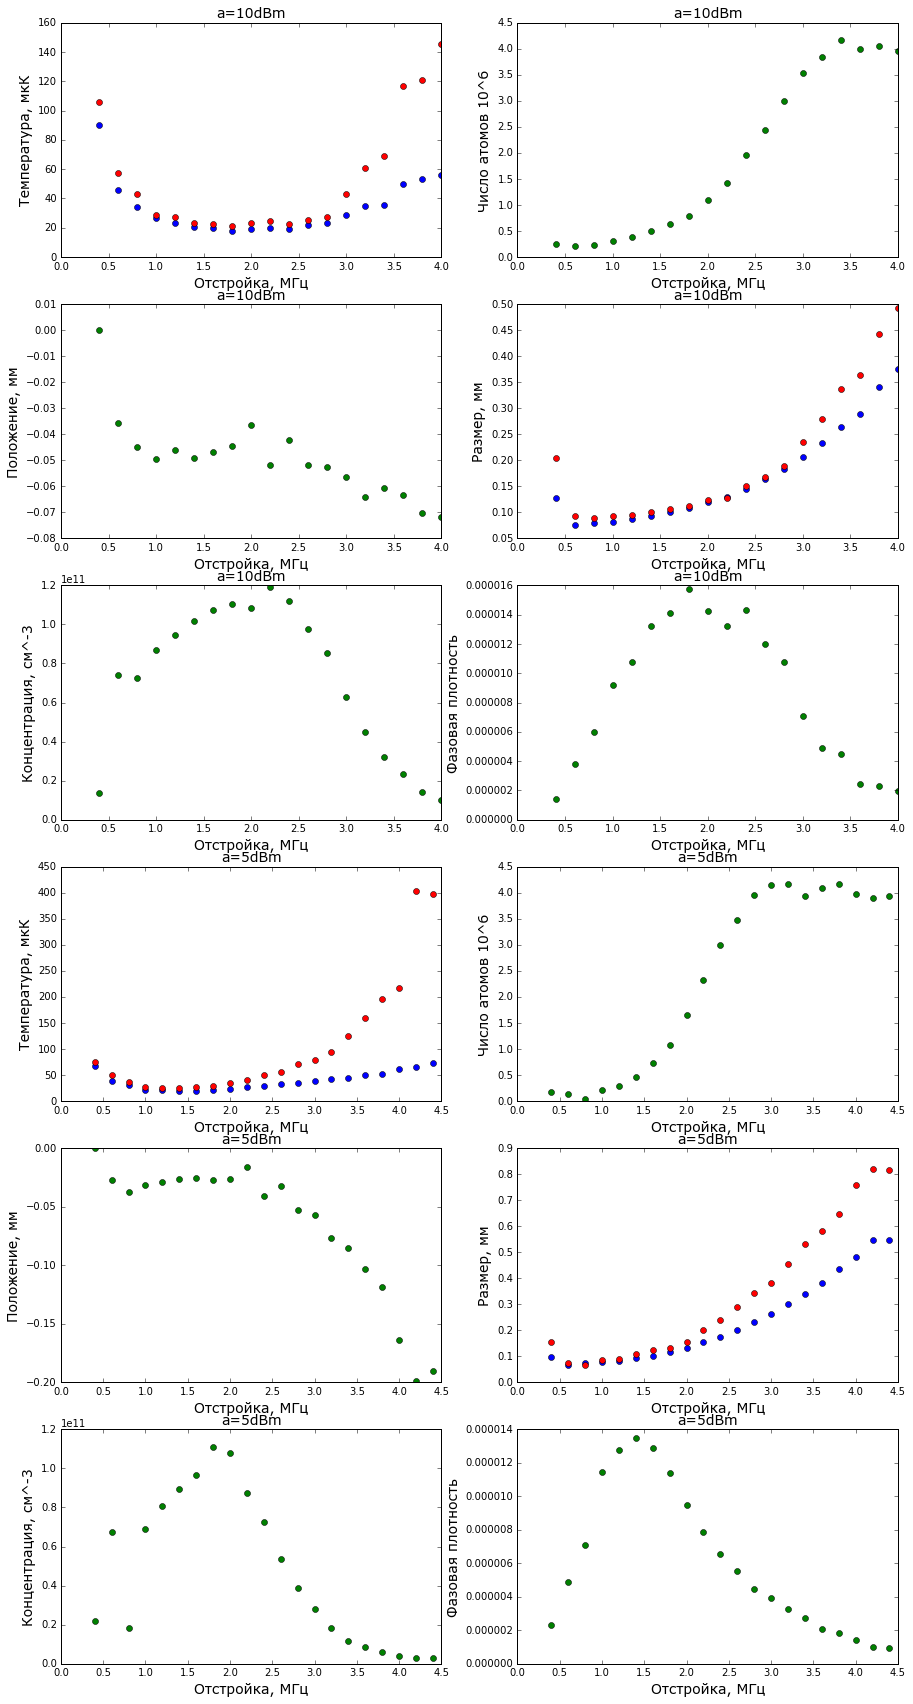

In [899]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T'})
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')

    

# от отстройки
telescope = 1
tmp, x_lbl = dependency_list(data, 'F', 1, 19)

drawing(tmp, x_lbl, 1, 'a=10dBm', ['bo', 'ro', 'go'])

vs_D_10wt_2016_05_12 = tmp

telescope = 1
tmp, x_lbl = dependency_list(data, 'F', 20, 40)

drawing(tmp, x_lbl, 2, 'a=5dBm', ['bo', 'ro', 'go'])

vs_D_5wt_2016_05_12 = tmp

# 2015_07_01

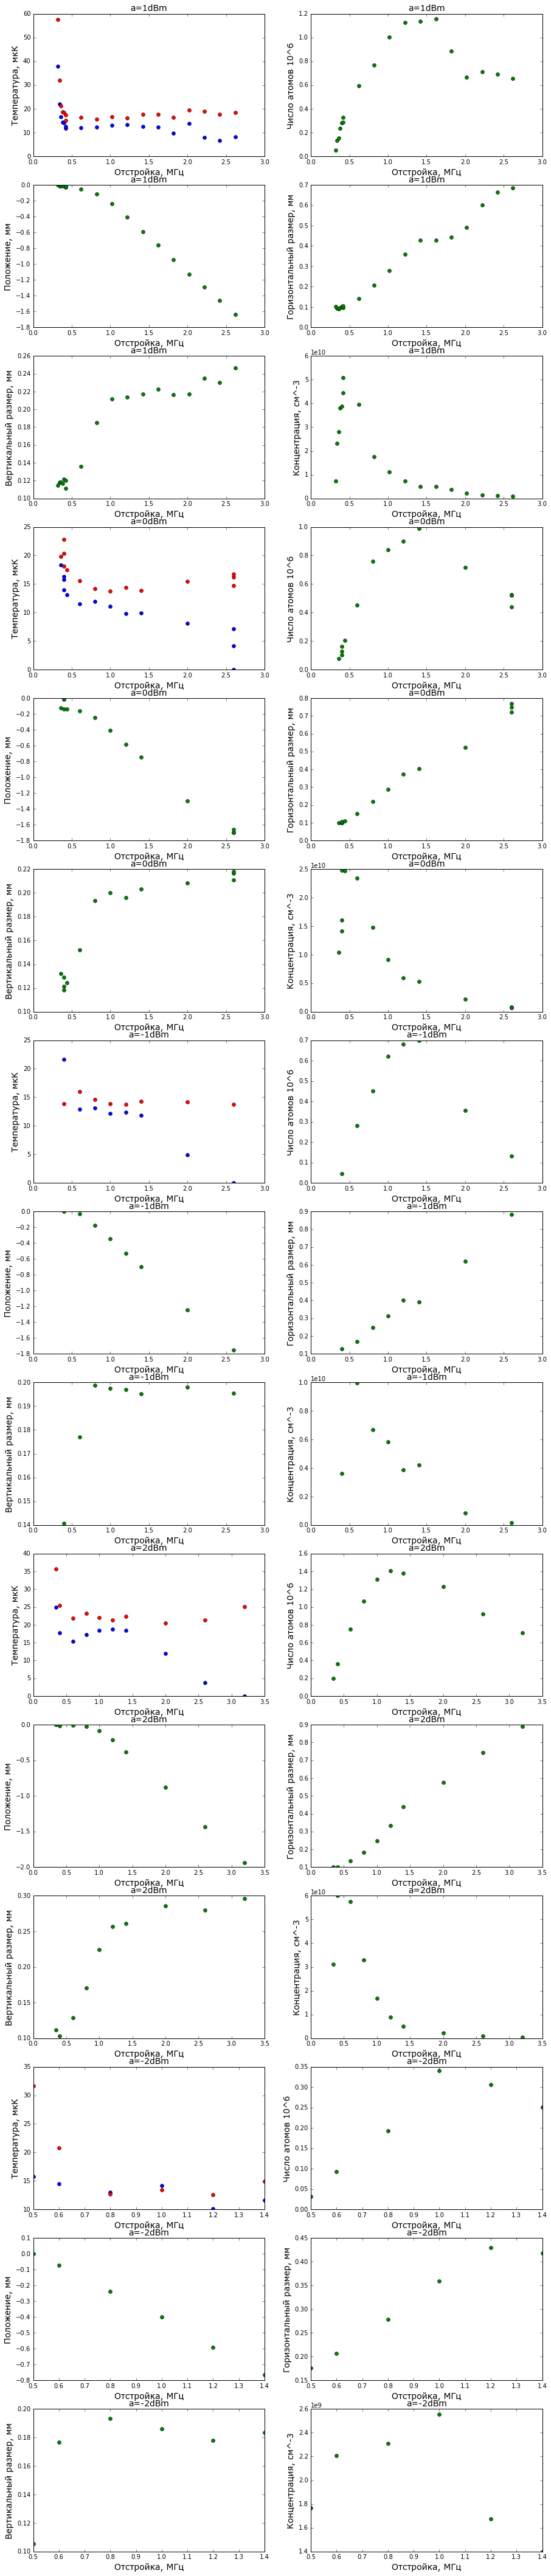

In [844]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2015, 7, 1, 0, 0), 'meas_type':'T'})
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')


# от отстройки
telescope = 1
tmp, x_lbl = dependency_list(data, 'F', 1, 18)

drawing(tmp, x_lbl, 1, 'a=1dBm', ['bo', 'ro', 'go'])

vs_D_74_2015_07_01 = tmp

telescope = 1
tmp, x_lbl = dependency_list(data, 'F', 19, 33)

drawing(tmp, x_lbl, 2, 'a=0dBm', ['bo', 'ro', 'go'])

vs_D_46_2015_07_01 = tmp

telescope = 1
tmp, x_lbl = dependency_list(data, 'F', 34, 41)

drawing(tmp, x_lbl, 3, 'a=-1dBm', ['bo', 'ro', 'go'])

vs_D_30_2015_07_01 = tmp

telescope = 1
tmp, x_lbl = dependency_list(data, 'F', 42, 51)

drawing(tmp, x_lbl, 4, 'a=2dBm', ['bo', 'ro', 'go'])

vs_D_110_2015_07_01 = tmp

telescope = 1
tmp, x_lbl = dependency_list(data, 'F', 52, 58)

drawing(tmp, x_lbl, 5, 'a=-2dBm', ['bo', 'ro', 'go'])

vs_D_20_2015_07_01 = tmp

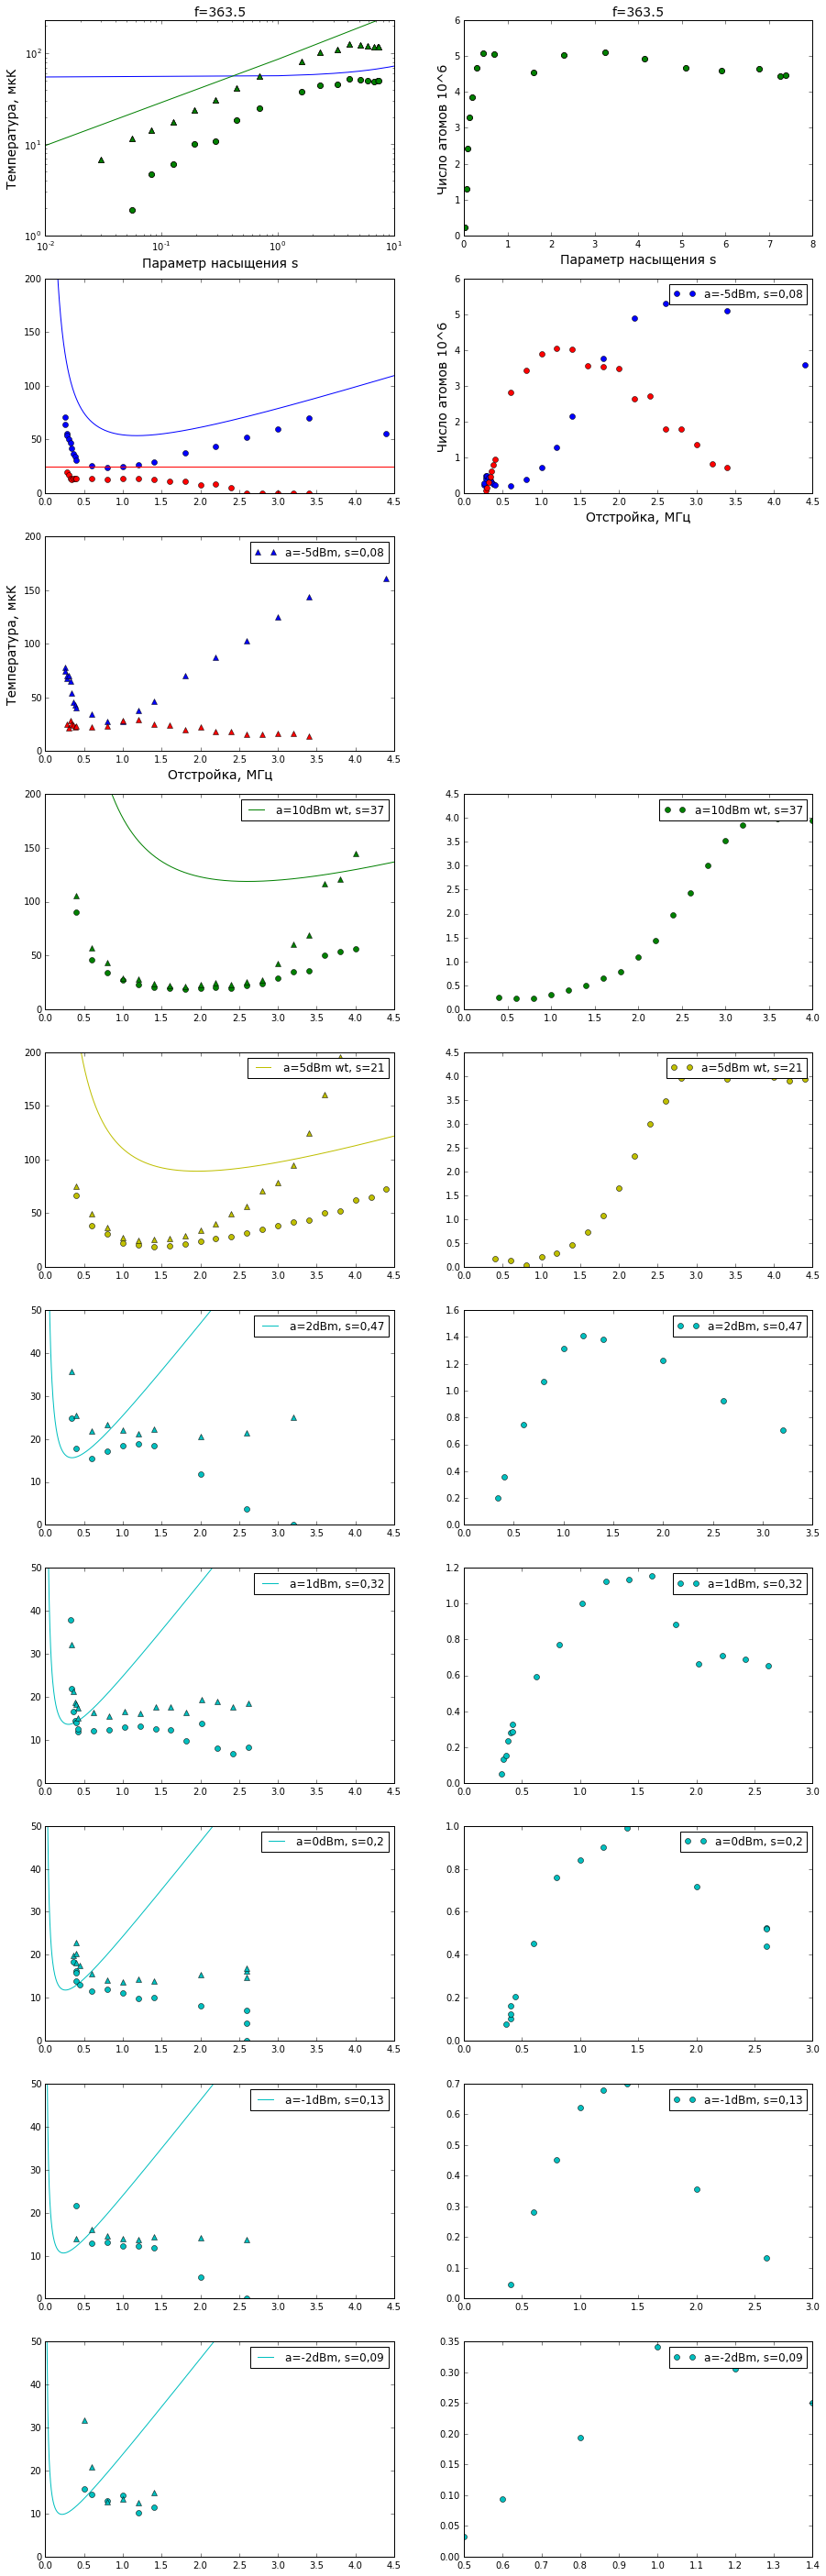

In [944]:
# от мощности

nop=20
figsize(15,5*nop)

s = linspace(0.01,1e3,1000)
δ = 2.4
subplot(nop,2,1)
plot(s,Temperature1(δ,s))
plot(s,Temperature2(δ,s))
gca().set_xscale('log')
gca().set_yscale('log')
axis([0.01,10,1,230])

Exper_s_old = [17,30,30,35,52]
Exper_T_old = [75,26,40,110,160]
Exper_s_2014_11 = [0.2,0.4,1.4,3,5]
Exper_T_2014_11 = [9,18,25,26,26.20]
Exper_s_2015_07 = [0.13,0.2,0.32,0.47]
Exper_Tx_2015_07 = [4.9,8.1,8.9,11.9]
# это горизонтальные Т
Exper_Ty_2015_07 = [14.2,15.5,17.6,20.6]
# это все для отстройки 2 МГц
Exper_Na_2015_07 = [0.13,0.4,0.6,0.9]

#plot(Exper_s_old,Exper_T_old,'yo')
#plot(Exper_s_2014_11,Exper_T_2014_11,'co')
#plot(Exper_s_2015_07,Exper_Tx_2015_07,'mo')
#plot(Exper_s_2015_07,Exper_Ty_2015_07,'m^')

#subplot(nop,2,2)
#plot(Exper_s_2015_07,Exper_Na_2015_07,'mo')

tmp = vs_P_2016_05_05
subplot(nop,2,1)
plot(tmp[:,0],tmp[:,1],'bo')
plot(tmp[:,0],tmp[:,2],'b^')
xlabel('Параметр насыщения s', fontsize=14, family="verdana")
ylabel('Температура, мкК', fontsize=14, family="verdana")
title('f=363.5', fontsize=14, family="verdana")
subplot(nop,2,2)
plot(tmp[:,0],tmp[:,3],'bo')
xlabel('Параметр насыщения s', fontsize=14, family="verdana")
ylabel('Число атомов 10^6', fontsize=14, family="verdana")
title('f=363.5', fontsize=14, family="verdana")


#tmp = vs_P_wt_2016_05_06
subplot(nop,2,1)
plot(tmp[:,0],tmp[:,1],'ro')
plot(tmp[:,0],tmp[:,2],'r^')
subplot(nop,2,2)
plot(tmp[:,0],tmp[:,3],'ro')

#tmp = vs_P_wrt_2016_05_11
subplot(nop,2,1)
plot(tmp[:,0],tmp[:,1],'go')
plot(tmp[:,0],tmp[:,2],'g^')
subplot(nop,2,2)
plot(tmp[:,0],tmp[:,3],'go')






# от отстройки

δ = linspace(0,4.5,1000)

tmp = vs_D_2016_05_07
subplot(nop,2,3)
s = powers[10]*1.38/320
plot(δ,Temperature1(δ,s),'b')
plot(tmp[:,0],tmp[:,1],'bo')
axis([0,4.5,0,200])
subplot(nop,2,5)
plot(tmp[:,0],tmp[:,2],'b^')
xlabel('Отстройка, МГц', fontsize=14, family="verdana")
ylabel('Температура, мкК', fontsize=14, family="verdana")
#title('a=10and5dBm', fontsize=14, family="verdana")
legend(['a=10dBm, s=7,4'])
axis([0,4.5,0,200])
subplot(nop,2,4)
plot(tmp[:,0],tmp[:,3],'bo')
xlabel('Отстройка, МГц', fontsize=14, family="verdana")
ylabel('Число атомов 10^6', fontsize=14, family="verdana")
#title('a=10and5dBm', fontsize=14, family="verdana")
legend(['a=10dBm, s=7,4'])


tmp = vs_D_2016_05_08
subplot(nop,2,3)
s = powers[-5]*1.38/320
#plot(δ,Temperature1(δ,s),'r')
plot(δ,Temperature2(δ,s),'r')
plot(tmp[:,0],tmp[:,1],'ro')
subplot(nop,2,5)
plot(tmp[:,0],tmp[:,2],'r^')
#axis([0,4.5,0,30])
legend(['a=-5dBm, s=0,08'])
subplot(nop,2,4)
plot(tmp[:,0],tmp[:,3],'ro')
legend(['a=-5dBm, s=0,08'])


tmp = vs_D_10wt_2016_05_12
subplot(nop,2,7)
s = powers[10]*1.38/320
plot(δ,Temperature1(δ,1.25*4*s),'g')
plot(tmp[:,0],tmp[:,1],'go')
plot(tmp[:,0],tmp[:,2],'g^')
axis([0,4.5,0,200])
legend(['a=10dBm wt, s=37'])
subplot(nop,2,8)
plot(tmp[:,0],tmp[:,3],'go')
legend(['a=10dBm wt, s=37'])

tmp = vs_D_5wt_2016_05_12
subplot(nop,2,9)
s = powers[5]*1.38/320
plot(δ,Temperature1(δ,1.25*4*s),'y')
plot(tmp[:,0],tmp[:,1],'yo')
plot(tmp[:,0],tmp[:,2],'y^')
axis([0,4.5,0,200])
legend(['a=5dBm wt, s=21'])
subplot(nop,2,10)
plot(tmp[:,0],tmp[:,3],'yo')
legend(['a=5dBm wt, s=21'])


tmp = vs_D_110_2015_07_01
subplot(nop,2,11)
s = 110*1.38/320
plot(δ,Temperature1(δ,s),'c')
plot(tmp[:,0],tmp[:,1],'co')
plot(tmp[:,0],tmp[:,2],'c^')
axis([0,4.5,0,50])
legend(['a=2dBm, s=0,47'])
subplot(nop,2,12)
plot(tmp[:,0],tmp[:,3],'co')
legend(['a=2dBm, s=0,47'])


tmp = vs_D_74_2015_07_01
subplot(nop,2,13)
s = 74*1.38/320
#print(s)
plot(δ,Temperature1(δ,s),'c')
plot(tmp[:,0],tmp[:,1],'co')
plot(tmp[:,0],tmp[:,2],'c^')
axis([0,4.5,0,50])
legend(['a=1dBm, s=0,32'])
subplot(nop,2,14)
plot(tmp[:,0],tmp[:,3],'co')
legend(['a=1dBm, s=0,32'])


tmp = vs_D_46_2015_07_01
subplot(nop,2,15)
s = 46*1.38/320
#print(s)
plot(δ,Temperature1(δ,s),'c')
plot(tmp[:,0],tmp[:,1],'co')
plot(tmp[:,0],tmp[:,2],'c^')
axis([0,4.5,0,50])
legend(['a=0dBm, s=0,2'])
subplot(nop,2,16)
plot(tmp[:,0],tmp[:,3],'co')
legend(['a=0dBm, s=0,2'])


tmp = vs_D_30_2015_07_01
#print(tmp)
subplot(nop,2,17)
s = 30*1.38/320
#print(s)
plot(δ,Temperature1(δ,s),'c')
plot(tmp[:,0],tmp[:,1],'co')
plot(tmp[:,0],tmp[:,2],'c^')
axis([0,4.5,0,50])
legend(['a=-1dBm, s=0,13'])
subplot(nop,2,18)
plot(tmp[:,0],tmp[:,3],'co')
legend(['a=-1dBm, s=0,13'])


tmp = vs_D_20_2015_07_01
subplot(nop,2,19)
s = 20*1.38/320
#print(s)
plot(δ,Temperature1(δ,s),'c')
plot(tmp[:,0],tmp[:,1],'co')
plot(tmp[:,0],tmp[:,2],'c^')
axis([0,4.5,0,50])
legend(['a=-2dBm, s=0,09'])
subplot(nop,2,20)
plot(tmp[:,0],tmp[:,3],'co')
legend(['a=-2dBm, s=0,09'])

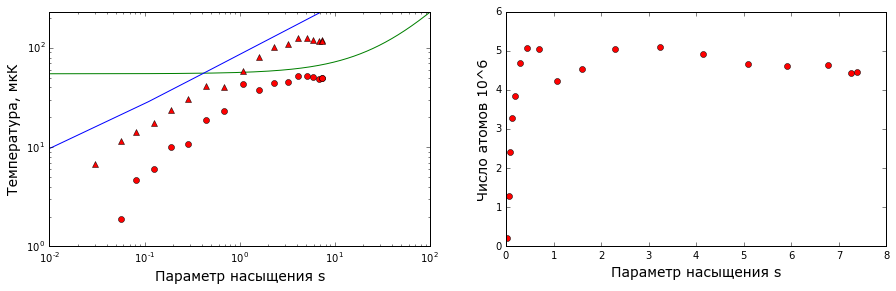

In [711]:
# от мощности

nop=20
figsize(15,5*nop)

s = linspace(0.01,1e3,10000)
δ = 2.4
subplot(nop,2,1)
plot(s,Temperature1(δ,s),'g')
plot(s,Temperature2(δ,s),'b')
gca().set_xscale('log')
gca().set_yscale('log')
axis([0.01,100,1,230])

Exper_s_old = [17,30,30,35,52]
Exper_T_old = [75,26,40,110,160]
Exper_s_2014_11 = [0.2,0.4,1.4,3,5]
Exper_T_2014_11 = [9,18,25,26,26.20]
Exper_s_2015_07 = [0.13,0.2,0.32,0.47]
Exper_Tx_2015_07 = [4.9,8.1,8.9,11.9]
# это горизонтальные Т
Exper_Ty_2015_07 = [14.2,15.5,17.6,20.6]
# это все для отстройки 2 МГц
Exper_Na_2015_07 = [0.13,0.4,0.6,0.9]

#plot(Exper_s_old,Exper_T_old,'yo')
#plot(Exper_s_2014_11,Exper_T_2014_11,'co')
#plot(Exper_s_2015_07,Exper_Tx_2015_07,'mo')
#plot(Exper_s_2015_07,Exper_Ty_2015_07,'m^')

#subplot(nop,2,2)
#plot(Exper_s_2015_07,Exper_Na_2015_07,'mo')

tmp = vs_P_2016_05_05
subplot(nop,2,1)
plot(tmp[:,0],tmp[:,1],'ro')
plot(tmp[:,0],tmp[:,2],'r^')
xlabel('Параметр насыщения s', fontsize=14, family="verdana")
ylabel('Температура, мкК', fontsize=14, family="verdana")
#title('f=363.5', fontsize=14, family="verdana")
subplot(nop,2,2)
plot(tmp[:,0],tmp[:,3],'ro')
xlabel('Параметр насыщения s', fontsize=14, family="verdana")
ylabel('Число атомов 10^6', fontsize=14, family="verdana")
#title('f=363.5', fontsize=14, family="verdana")

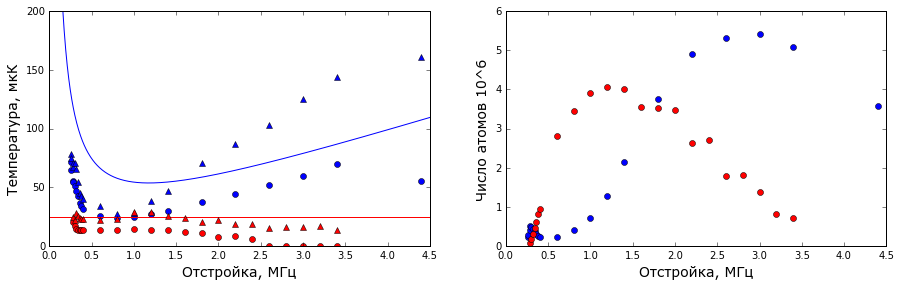

In [716]:
# от отстройки

δ = linspace(0,4.5,1000)

tmp = vs_D_2016_05_07
subplot(nop,2,3)
s = powers[10]*1.38/320
plot(δ,Temperature1(δ,s),'b')
plot(tmp[:,0],tmp[:,1],'bo')
plot(tmp[:,0],tmp[:,2],'b^')
xlabel('Отстройка, МГц', fontsize=14, family="verdana")
ylabel('Температура, мкК', fontsize=14, family="verdana")
#title('a=10and5dBm', fontsize=14, family="verdana")
#legend(['s=7,4','s=7,4','s=0,08'])
axis([0,4.5,0,200])
subplot(nop,2,4)
plot(tmp[:,0],tmp[:,3],'bo')
xlabel('Отстройка, МГц', fontsize=14, family="verdana")
ylabel('Число атомов 10^6', fontsize=14, family="verdana")
#title('a=10and5dBm', fontsize=14, family="verdana")
#legend(['s=7,4','s=7,4','s=0,08'])


tmp = vs_D_2016_05_08
subplot(nop,2,3)
s = powers[-5]*1.38/320
plot(δ,Temperature2(δ,s),'r')
plot(tmp[:,0],tmp[:,1],'ro')
plot(tmp[:,0],tmp[:,2],'r^')
#axis([0,4.5,0,30])
subplot(nop,2,4)
plot(tmp[:,0],tmp[:,3],'ro')

In [810]:
# Шаблон
xx = []
yy = []
for d in data:
    tbl = d['avr_table']
    x = tbl.folder
    y = tbl.fit1D_x.sigma
    ff = d['fits'][0]
    fit_func = usfuncs.cloud_expansion0
    plot(x,fit_func(x,*ff[1]))
    plot(x,y,'o',label=d['date_meas'])
legend()
ylim(bottom=0)

In [ ]:
os.chdir(r'/Users/artemgolovizin/Downloads/2015_12_01')

In [ ]:
old_ks = dict()

In [ ]:
with open('all_data.txt', 'rb') as handle:
    data = pickle.loads(handle.read())

In [ ]:
data.keys()

In [ ]:
data['01 t']

In [ ]:
with open('all_data.txt', 'rb') as handle:
    data = pickle.loads(handle.read())
shot_typeN = 1
ks = list(data.keys())
ks.sort()
ch_boxes = dict()
ks_n = []
for k in ks:
    # optional - uncomment line below to sift only keys with specific marker, as 'CL'
#    if 'CL' not in k.upper(): continue
    ch_boxes[k]=old_ks.get(k,True)
    ks_n.append(k)
ks = ks_n
fg = None   
def plot_gr(l_pos,**ar):
    fig,ax = subplots() 
    global fg, old_ks
    old_ks = dict()
    for k in ks:
        old_ks[k]=ar[k]
        if ar[k]:
            d1 = impr.get_avr_data(data[k]['data'], shot_typeN, 'fit1D_x',2)
            errorbar(**d1)
#             d1['fmt']='ro'
#             d1['label']='fit1D_x'
#             val=datat[k]
#             x,y=impr.data2_sort(val[0],val[1])
#             # here it's time to modify data
# #             x = mod_from_AOM_to_real_freq(x, k, 420)
#             #x,y = x[1:],y[1:]
#             ax.plot(x,y,'-*',label=k)
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
    #xscale('log')
    #xlabel('Current, A')
    #xlabel('AOM frequency, MHz')
    xlabel('detuning, MHz') #in real frequencyes
    ylabel('atoms number, a.u.')
    ylim(bottom=0)
    #start, end = ax.get_xlim()
    #print(ax.get_xlim())
    #ax.xaxis.set_ticks(arange(start, end, 0.1))
    #axvline(x=l_pos)
    fg = fig
    
ter = interactive(plot_gr,l_pos=(150,250,0.1),**ch_boxes)
ter.box_style='info'
display(ter)

In [ ]:
help(interactive)

###For managing clock line shift and broadening

#### Построение списка сканирования

In [ ]:
res = array(range(-7,7, 1))/10 + 420.1
rr = ''
for x in res:
    rr += str(x) + ' '
print(rr)